In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.model_selection as ms
from imblearn.combine import SMOTETomek
from collections import Counter
import math

pd.options.mode.chained_assignment = 'warn'

UNREST_COLUMNS = ["EVENT_ID_CNTY", 
                "EVENT_DATE", 
                "EVENT_TYPE", 
                "REGION", 

                "TIMESTAMP"]

CASES_COLUMNS = ["iso_code",
                "continent",
                "location", 
                "date", 
                "total_cases", 
                "new_cases", 
                "total_deaths", 
                "reproduction_rate", 
                "hosp_patients", 
                "positive_rate", 
                "stringency_index", 
                "population",
                "median_age",
                "gdp_per_capita",
                "life_expectancy",
            ]
def multiPrecision(y, y_pred, **kwargs):
    return precision_score(y, y_pred, average="micro", **kwargs)

def multiRecall(y, y_pred, **kwargs):
    return precision_score(y, y_pred, average="micro", **kwargs)

def serialize(dataFrame, column):
    return [x for x in range(len(dataFrame[column].unique()))]

#Replace a column in a dataframe with a serialized version
def replaceDict(dataFrame, column):
    vals = serialize(dataFrame, column)
    return dict(zip(dataFrame[column].unique(), vals))

def oneToOne(df, column):
    count = []
    ret = pd.DataFrame()
    
    count = [{"col": val, "count": df[df[column] == val].shape[0]} for val in df[column].unique()]
    count.sort(key=lambda x: x.get("count"))
    i = 1
    for col in count:
        if ret.empty:
            ret = pd.DataFrame(df[df[column] == col.get("col")].sample(math.floor(count[0].get("count") * i), replace=True).drop_duplicates())
        else:
            ret = ret.append(df[df[column] == col.get("col")].sample(math.floor(count[0].get("count") * i), replace=True).drop_duplicates())
        i = i + 10
    return ret
    
    count = [df[df[column] == val].shape[0] for val in df[column].unique()]
    count.sort()

def getData(    ):
    #Read in data from files
    unrest_df = pd.read_csv("./coronavirus_Oct31.csv")
    #Remove rows with event type of strategic developments
    unrest_df = unrest_df[unrest_df.EVENT_TYPE != 'Strategic developments']
 
    covid_cases_df = pd.read_csv("./owid-covid-data.csv")

    unrest_df = unrest_df[unrest_df.columns.intersection(UNREST_COLUMNS)]
    covid_cases_df = covid_cases_df[covid_cases_df.columns.intersection(CASES_COLUMNS)]
    #Get data based on the input iso country codes
    #unrest = multiContains(unrest_df, "EVENT_ID_CNTY", isoCodes)
    #cases = multiSearch(covid_cases_df, 'iso_code', isoCodes)

    #Convert "date" type columns to dates
    unrest_df.EVENT_DATE = pd.to_datetime(unrest_df.EVENT_DATE)
    unrest_df.EVENT_ID_CNTY = unrest_df.EVENT_ID_CNTY.astype(str).str[:3]
    covid_cases_df.date = pd.to_datetime(covid_cases_df.date)
    #Merge the two datasets with an inner join on the date fields
    merge = unrest_df.merge(covid_cases_df, how="inner", left_on=["EVENT_DATE", 'EVENT_ID_CNTY'], right_on=["date", "iso_code"])
    #merge = merge.drop_duplicates(subset=['EVENT_DATE', 'EVENT_ID_CNTY'])
    #Drop the iso code to avoid duplicates
    
    merge = merge.drop(['EVENT_ID_CNTY'], axis=1)
    #Drop remaining duplicates
    #merge = merge.drop_duplicates()
    print(merge.shape)
    #Get the list of event types in this particular set of data
    #issueType = merge['EVENT_TYPE']
    #Serialize the data and return it as the expected values for training
    #issueType = issueType.replace(replaceDict(unrest_df, "EVENT_TYPE"))
    result = pd.DataFrame()
    result = merge
    #shuffle result to ensure samples from the same country don't appear in the same slices
    result = result.sample(frac=1).reset_index(drop=True)
    issueType = result['EVENT_TYPE']
    #Serialize the data and return it as the expected values for training
    issueType = issueType.replace(replaceDict(unrest_df, "EVENT_TYPE"))

    #Drop remaining unneeded data
    result = result.drop(['EVENT_TYPE', 'EVENT_DATE', 'REGION', 'iso_code', 'continent', 'location', 'date', 'TIMESTAMP'], axis=1).fillna(0)

    return result, issueType

min_max_scaler = MinMaxScaler()

X, y = getData()
X = min_max_scaler.fit_transform(X)

#keep 20% of the test data for later unseen experiment
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2)

#sample data
resampler = SMOTETomek(random_state=0)
X_train, y_train = resampler.fit_resample(X_train, y_train)

#crossval training using gridsearch, keeping solver and activation algorithm constsant
#check epoch number, batch size, hidden layer size
#check alpha where alpha=1/C, C=L2 Penalty
#use 10-fold KFold on the test set
cvl_model = MLPClassifier(solver="adam", activation="relu")
cvl_ranges_1 = {
    "max_iter": [1,5,10,25,50,100],
    "batch_size": [100,200,300],
    "hidden_layer_sizes": [5,10,15,20,50,75,100],
    "alpha": [1/1,1/5,1/10,1/100,1/1000]
}
cvl_ranges_2 = {
    "max_iter": [50,100,150,200],
    "batch_size": [50,100,150,200],
    "hidden_layer_sizes": [(50,),(75,),(100,),(125,),(150,)],
    "alpha": [1/1,1/5,1/10,1/100,1/1000]
}
cvl_grid = ms.GridSearchCV(cvl_model, cvl_ranges_2, n_jobs=-1, cv=5, scoring="f1_micro", verbose=1)

model = cvl_grid.fit(X_train, y_train)
print("best params:\n", model.best_params_)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("training\n", classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

print("test\n", classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))


(14596, 19)
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 136.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 256.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 292.0min finished
best params:
 {'alpha': 0.001, 'batch_size': 50, 'hidden_layer_sizes': (150,), 'max_iter': 200}
training
               precision    recall  f1-score   support

           0       0.76      0.71      0.73     10108
           1       0.60      0.55      0.57      9899
           2       0.87      0.89      0.88     10113
           3       0.65      0.71      0.68      9907
           4       0.

     alpha  batch_size hidden_layer_sizes  max_iter  F1 Accuracy
0    1.000          50              (50,)        50     0.453336
1    1.000          50              (50,)       100     0.453037
2    1.000          50              (50,)       150     0.439833
3    1.000          50              (50,)       200     0.448417
4    1.000          50              (75,)        50     0.450667
..     ...         ...                ...       ...          ...
395  0.001         200             (125,)       200     0.744254
396  0.001         200             (150,)        50     0.701215
397  0.001         200             (150,)       100     0.726648
398  0.001         200             (150,)       150     0.742382
399  0.001         200             (150,)       200     0.745569

[400 rows x 5 columns]


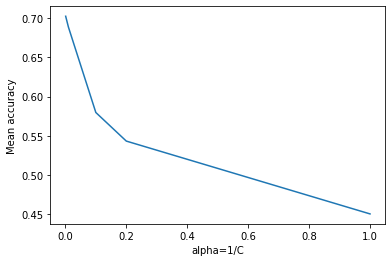

In [26]:
import matplotlib.pyplot as plt

cross_val_df = pd.concat([pd.DataFrame(model.cv_results_["params"]), pd.DataFrame(model.cv_results_["mean_test_score"], columns=["F1 Accuracy"])], axis=1)

print(cross_val_df)

alpha_keys = cross_val_df.alpha.unique()
alpha_dict = {}
for a in alpha_keys:
    alpha_dict[a] = cross_val_df.loc[cross_val_df.alpha == a, "F1 Accuracy"].iloc[4]
fig = plt.figure()
ax = plt.axes()
ax.plot(alpha_keys, alpha_dict.values())
ax.set_xlabel("alpha=1/C")
ax.set_ylabel("Mean accuracy")

plt.show()




Model ROC AUC Score:  0.8609373010856668
Baseline ROC AUC Score:  0.48510361645576605
Classification Report Model
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      2562
           1       0.22      0.49      0.31       271
           2       0.10      0.56      0.17        16
           3       0.13      0.60      0.21        70
           4       0.03      1.00      0.06         1

    accuracy                           0.68      2920
   macro avg       0.29      0.67      0.31      2920
weighted avg       0.87      0.68      0.75      2920

Classification Report Baseline
              precision    recall  f1-score   support

           0       0.89      0.20      0.33      2562
           1       0.10      0.23      0.14       271
           2       0.00      0.12      0.01        16
           3       0.01      0.10      0.02        70
           4       0.00      1.00      0.00         1

    accuracy                           0

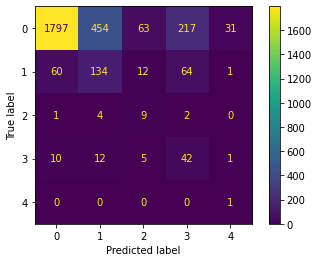

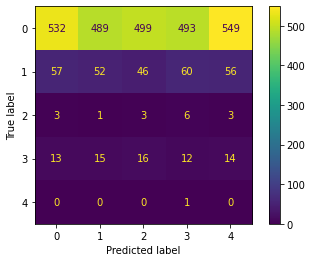

In [76]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

most_frequent_dummy = DummyClassifier("stratified")
most_frequent_dummy.fit(X_train, y_train)
baseline_predicts = most_frequent_dummy.predict(X_test)

print("Model ROC AUC Score: ", roc_auc_score(y_test, model.predict_proba(X_test), average="macro", multi_class="ovr"))
print("Baseline ROC AUC Score: ", roc_auc_score(y_test, most_frequent_dummy.predict_proba(X_test), average="macro", multi_class="ovr"))

print("Classification Report Model")
print(classification_report(y_test, y_test_pred))
print("Classification Report Baseline")
print(classification_report(y_test, baseline_predicts))

print("Confusion Matrix Model")
plot_confusion_matrix(model, X_test, y_test)

print("Confusion Matrix Baseline")
plot_confusion_matrix(most_frequent_dummy, X_test, y_test)